In [105]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert
import holidays


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [106]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//RevenuePessengerDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_penumpang': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# Drop the original date column
# df = df.drop('date', axis=1)
# df = df.set_index('date')
# df = df.sort_index()

df

,y,date,org,kode_org,des,kode_des
0,13755000,2022-12-09,TANJUNG PRIOK,431,NABIRE,982
1,10087000,2022-12-24,TANJUNG PRIOK,431,NABIRE,982
2,7336000,2023-01-07,TANJUNG PRIOK,431,NABIRE,982
3,15589000,2023-01-21,TANJUNG PRIOK,431,NABIRE,982
4,4585000,2023-02-04,TANJUNG PRIOK,431,NABIRE,982
...,...,...,...,...,...,...
85471,2980000,2023-05-11,AMBON,946,BAU-BAU,921
85472,3011000,2023-01-11,AMBON,946,BAU-BAU,921
85473,3011000,2023-03-31,AMBON,946,BAU-BAU,921
85474,3011000,2023-05-01,AMBON,946,BAU-BAU,921


In [107]:
# data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
# data = data.groupby(['date','year','month','day', 'weekday', 'weekofmonth', 'hijri_year', 'hijri_month', 'hijri_day'])['y'].sum()

# data = pd.DataFrame(data)
# data

df = df.groupby(['kode_des', 'date'], as_index=False)['y'].sum()
df

,kode_des,date,y
0,144,2022-12-03,27239000
1,144,2022-12-04,133154000
2,144,2022-12-10,120964000
3,144,2022-12-11,390796000
4,144,2022-12-16,95017000
...,...,...,...
5765,983,2023-05-16,17597000
5766,983,2023-05-19,758000
5767,983,2023-05-20,448000
5768,983,2023-05-22,1436000


In [108]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekofmonth'] = df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
df['hijri_year'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().year)
df['hijri_month'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_day'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().day)

df

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day
0,144,2022-12-03,27239000,2022,12,3,5,1,1444,5,9
1,144,2022-12-04,133154000,2022,12,4,6,1,1444,5,10
2,144,2022-12-10,120964000,2022,12,10,5,2,1444,5,16
3,144,2022-12-11,390796000,2022,12,11,6,2,1444,5,17
4,144,2022-12-16,95017000,2022,12,16,4,3,1444,5,22
...,...,...,...,...,...,...,...,...,...,...,...
5765,983,2023-05-16,17597000,2023,5,16,1,3,1444,10,26
5766,983,2023-05-19,758000,2023,5,19,4,3,1444,10,29
5767,983,2023-05-20,448000,2023,5,20,5,3,1444,10,30
5768,983,2023-05-22,1436000,2023,5,22,0,4,1444,11,2


In [109]:
id_holidays = holidays.ID(years=range(2020, 2024))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')
df_holidays

,day,event
0,2020-12-09,Hari Pemilihan
1,2020-01-01,Tahun Baru Masehi
2,2020-01-25,Tahun Baru Imlek
3,2020-03-25,Hari Suci Nyepi
4,2020-05-24,Hari Raya Idul Fitri
...,...,...
59,2023-05-01,Hari Buruh Internasional
60,2023-05-18,Kenaikan Yesus Kristus
61,2023-06-01,Hari Lahir Pancasila
62,2023-08-17,Hari Kemerdekaan Republik Indonesia


In [110]:
df['is_holiday']=df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
df.loc[df['is_holiday']==1]

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day,is_holiday
20,144,2023-01-22,315339000,2023,1,22,6,4,1444,6,29,1
42,144,2023-04-07,221400000,2023,4,7,4,1,1444,9,16,1
51,144,2023-05-01,455164000,2023,5,1,0,1,1444,10,11,1
67,246,2023-01-01,3140000,2023,1,1,6,1,1444,6,8,1
71,246,2023-01-22,6526000,2023,1,22,6,4,1444,6,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5661,982,2023-05-18,396000,2023,5,18,3,3,1444,10,28,1
5685,983,2023-01-01,37198000,2023,1,1,6,1,1444,6,8,1
5701,983,2023-01-22,2470000,2023,1,22,6,4,1444,6,29,1
5740,983,2023-04-07,6460000,2023,4,7,4,1,1444,9,16,1


In [111]:

data = df.loc[df['kode_des'] == 431]
data = data.groupby(['date','year','month','day', 'weekday', 'weekofmonth','hijri_month', 'hijri_day', 'hijri_year','is_holiday'])['y'].sum()

data = pd.DataFrame(data)

data = data.reset_index()
data = data.set_index('date')

# # Resample to weekly frequency
data = data.resample('W').sum()
data = data.reset_index()
data = data.set_index(['year','month','day', 'weekday', 'weekofmonth','hijri_month', 'hijri_day', 'hijri_year','is_holiday'])
data = data.drop('date', axis =1 )
data

y
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday            
8088  48    10  18      4           20          34        5776       0            295558000
14154 84    56  21      11          35          98        10108      0           1268630000
            105 21      18          35          147       10108      0           2093326000
            154 21      25          36          166       10108      1           1478145000
14155 73    172 21      28          42          35        10108      1           1558837000
14161 7     35  21      8           42          84        10108      0            619071000
            84  21      15          42          133       10108      0           2093815000
            133 21      22          42          182       10108      1           1176897000
            182 21      29          49          28        10108      0           1375931000
      12    76  21      15          49          77        10108      0            845766000
      14    63  21      12          49          126       10108      0            194110000
            112 21      19          49          175       10108      1             34093000
8092  8     88  8       14          31          37        5776       0             39039000
14161 19    70  21      13          56          70        10108      0            690480000
      21    63  21      12          56          119       10108      0           1214640000
            112 21      19          56          168       10108      0           1041182000
            161 21      26          60          97        10108      1           1055540000
      23    148 21      25          63          56        10108      0            977107000
      28    42  21      9           63          105       10108      1           2665461000
12138 24    75  15      13          54          129       8664       0            695836000
14161 28    140 21      23          66          116       10108      2           1466747000
            189 21      30          70          49        10108      0           1434682000
      35    28  21      7           70          98        10108      1           2547856000
            77  21      14          70          147       10108      0           1156716000
            126 21      21          71          166       10108      1            352080000
12138 30    150 18      24          66          30        8664       0             48359000
6069  15    90  3       15          33          30        4332       0              4237000
12138 36    48  18      9           66          114       8664       0             15636000

In [112]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday            
8088  48    10  18      4           20          34        5776       0            295558000
14154 84    56  21      11          35          98        10108      0           1268630000
            105 21      18          35          147       10108      0           2093326000
            154 21      25          36          166       10108      1           1478145000
14155 73    172 21      28          42          35        10108      1           1558837000
14161 7     35  21      8           42          84        10108      0            619071000
            84  21      15          42          133       10108      0           2093815000
            133 21      22          42          182       10108      1           1176897000
            182 21      29          49          28        10108      0           1375931000
      12    76  21      15          49          77        10108      0            845766000
      14    63  21      12          49          126       10108      0            194110000
            112 21      19          49          175       10108      1             34093000
8092  8     88  8       14          31          37        5776       0             39039000
14161 19    70  21      13          56          70        10108      0            690480000
      21    63  21      12          56          119       10108      0           1214640000
            112 21      19          56          168       10108      0           1041182000
            161 21      26          60          97        10108      1           1055540000
      23    148 21      25          63          56        10108      0            977107000
      28    42  21      9           63          105       10108      1           2665461000
12138 24    75  15      13          54          129       8664       0            695836000
14161 28    140 21      23          66          116       10108      2           1466747000
            189 21      30          70          49        10108      0           1434682000
      35    28  21      7           70          98        10108      1           2547856000
            77  21      14          70          147       10108      0           1156716000
            126 21      21          71          166       10108      1            352080000
12138 30    150 18      24          66          30        8664       0             48359000
6069  15    90  3       15          33          30        4332       0              4237000
12138 36    48  18      9           66          114       8664       0             15636000

In [113]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [114]:
len(data)

28

In [115]:
steps = 12
train = data[:-steps]
test  = data[-steps:]

In [116]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [117]:
scaled_train[:10]

array([[0.12694189],
       [0.59937069],
       [0.99976259],
       [0.70109073],
       [0.74026689],
       [0.28400823],
       [1.        ],
       [0.5548341 ],
       [0.65146559],
       [0.3940692 ]])

In [118]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [119]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [120]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [121]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [122]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
4/4 [==============================] - 2s 5ms/step - loss: 0.1636
Epoch 2/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1329
Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1080
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0952
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0660
Epoch 6/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 8/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0559
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 10/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 11/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 12/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 13/50
4/4 [==============================] - 0s 8ms/step - loss: 0.

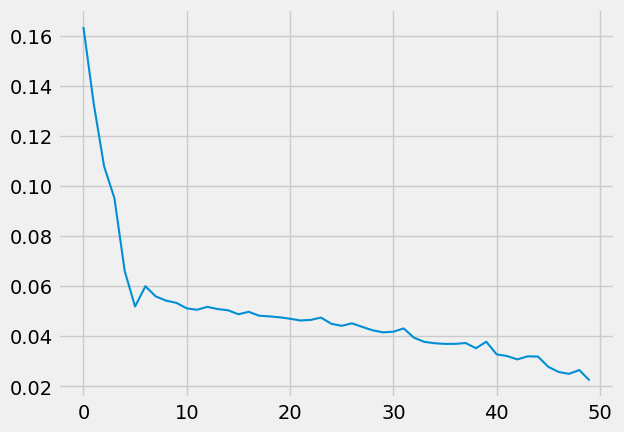

In [123]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [124]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 181ms/step


array([[0.5227975]], dtype=float32)

In [125]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [126]:
test_predictions

[array([0.5227975], dtype=float32),
 array([0.5071479], dtype=float32),
 array([0.6284466], dtype=float32),
 array([0.5637187], dtype=float32),
 array([0.55773515], dtype=float32),
 array([0.44249377], dtype=float32),
 array([0.35265553], dtype=float32),
 array([0.2746581], dtype=float32),
 array([0.23043802], dtype=float32),
 array([0.23009872], dtype=float32),
 array([0.26695275], dtype=float32),
 array([0.28612256], dtype=float32)]

In [127]:
test.head()

y
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday            
14161 21    161 21      26          60          97        10108      1           1055540000
      23    148 21      25          63          56        10108      0            977107000
      28    42  21      9           63          105       10108      1           2665461000
12138 24    75  15      13          54          129       8664       0            695836000
14161 28    140 21      23          66          116       10108      2           1466747000

In [128]:
true_predictions = scaler.inverse_transform(test_predictions)

In [129]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_11832\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


y   
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday               
14161 21    161 21      26          60          97        10108      1           1055540000  \
      23    148 21      25          63          56        10108      0            977107000   
      28    42  21      9           63          105       10108      1           2665461000   
12138 24    75  15      13          54          129       8664       0            695836000   
14161 28    140 21      23          66          116       10108      2           1466747000   

                                                                                  Predictions  
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday                
14161 21    161 21      26          60          97        10108      1           1.110911e+09  
      23    148 21      25          63          56        10108      0           1.078677e+09  
      28    42  21      9           63          105       10108      1           1.328518e+09  
12138 24    75  15      13          54          129       8664       0           1.195197e+09  
14161 28    140 21      23          66          116       10108      2           1.182872e+09

<Axes: xlabel='year,month,day,weekday,weekofmonth,hijri_month,hijri_day,hijri_year,is_holiday'>

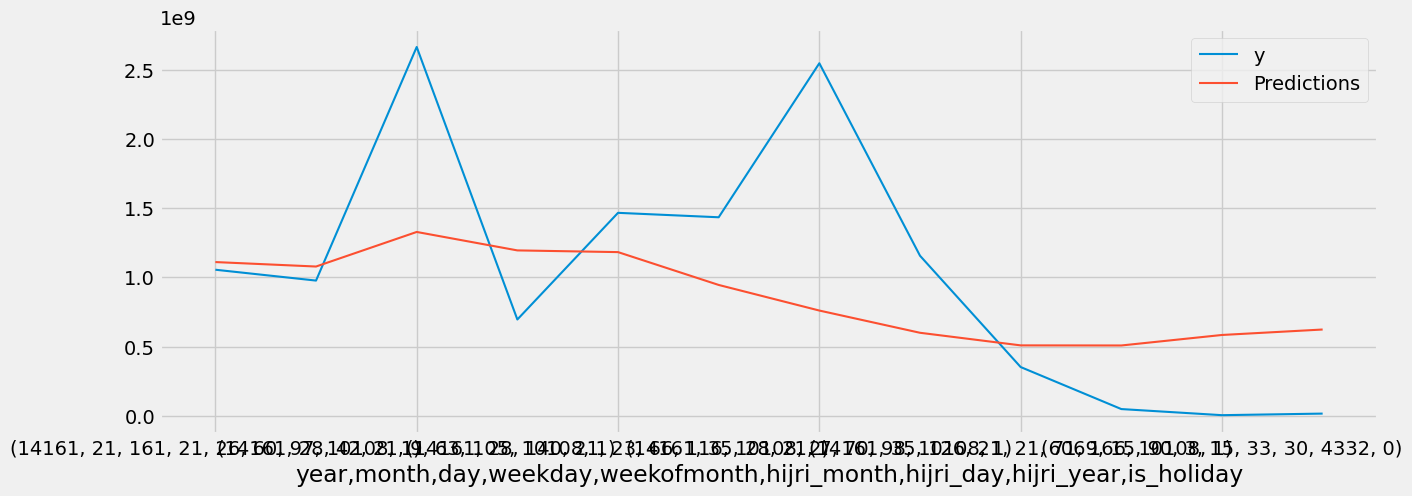

In [130]:
test.plot(figsize=(14,5))

In [131]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 753671478.369519
Mean Value of Test Dataset: 1035021416.6666666
